# Predict Podcast Listening Time

## Overview

- **Goal**: Predict the listening time of podcast episodes
- **Evaluation Metric**: Root Mean Squared Error (RMSE)
- **Submission Format**: CSV file with predictions for each podcast ID

### Submission File Format
```csv
id,Listening_Time_minutes
750000,45.437
750001,45.437
750002,45.437
```

# Dataset Description

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Podcast Listening Time Prediction dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

## Files

- **train.csv** - the training dataset; Listening_Time_minutes is the target
- **test.csv** - the test dataset; your objective is to predict the Listening_Time_minutes for each row
- **sample_submission.csv** - a sample submission file in the correct format.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

# Set up visualization settings
plt.style.use('ggplot')
sns.set_palette("Paired")


In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

sample_submission.head()

,id,Listening_Time_minutes
0,750000,45.437
1,750001,45.437
2,750002,45.437
3,750003,45.437
4,750004,45.437


# Basic data exploration steps



In [5]:
# Get basic information about the dataset
print("Training set shape:", train.shape)
print("\nBasic information about the training set:")

train.info()


Training set shape: (750000, 12)

Basic information about the training set:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-n

In [6]:

# Display first few rows
print("\nFirst few rows of the training set:")
train.head()


First few rows of the training set:


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [7]:

# Basic statistical summary
print("\nStatistical summary of the training set:")
train.describe()



Statistical summary of the training set:


,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348855,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


# Key insights from descriptive statistics and their implications:

## 1. Episode Length:
- Average episode length is ~65 minutes, suggesting this is a typical podcast format length
- The wide range (36-94 minutes) indicates high variability in content formats
- The presence of very long episodes (up to 5.4 hours) may require special handling in modeling
- 12% missing data implies need for robust imputation strategy

## 2. Host Popularity:
- Mean popularity of 60% suggests hosts are generally well-established
- The broad range (39-80%) indicates diverse host experience levels
- Complete data means this will be a reliable predictor variable

## 3. Guest Popularity:
- Lower average than hosts suggests guests tend to be less prominent figures
- High variability indicates mix of unknown and celebrity guests
- 19% missing data likely represents episodes without guests
- Values over 100% may indicate data quality issues needing investigation

## 4. Number of Ads:
- Low average (1.35) suggests moderate ad presence
- Distribution shows most episodes are not ad-heavy
- Extreme outliers (104 ads) need investigation - possible data errors
- Near-complete data makes this a reliable feature

## 5. Listening Time (Target Variable):
- 45-minute average suggests users typically don't complete longer episodes
- Wide range (23-65 minutes) indicates varied engagement levels
- 120-minute cap may affect modeling of longer episodes
- Complete data ensures robust model training

## Overall implications:
- Need strategies for handling missing data, especially in episode length and guest popularity
- Should investigate and possibly clean outlier values
- May need to normalize or bin features with wide ranges
- Complete target variable data enables reliable model development

In [8]:

# Check for missing values
print("\nMissing values in training set:")
train.isnull().sum()


Missing values in training set:


id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

# Insights from missing values analysis:

## 1. Most features have complete data (0 missing values), including:
   - Basic identifiers (id)
   - Content metadata (Podcast_Name, Episode_Title)
   - Categorical features (Genre, Publication_Day, Publication_Time, Episode_Sentiment)
   - Target variable (Listening_Time_minutes)

## 2. Significant missing values in:
   - Guest_Popularity_percentage: 146,030 missing values (19.5% of data)
   - Episode_Length_minutes: 87,093 missing values (11.6% of data)
   This suggests some episodes may not have guests, and some episode lengths weren't recorded

## 3. Number_of_Ads has only 1 missing value, which is negligible

## Implications:
- Need to handle missing Episode_Length_minutes in modeling
- May need to create a 'No Guest' category or impute Guest_Popularity_percentage
- Single missing Number_of_Ads value can be imputed with mean/median

# Analyze the target variable

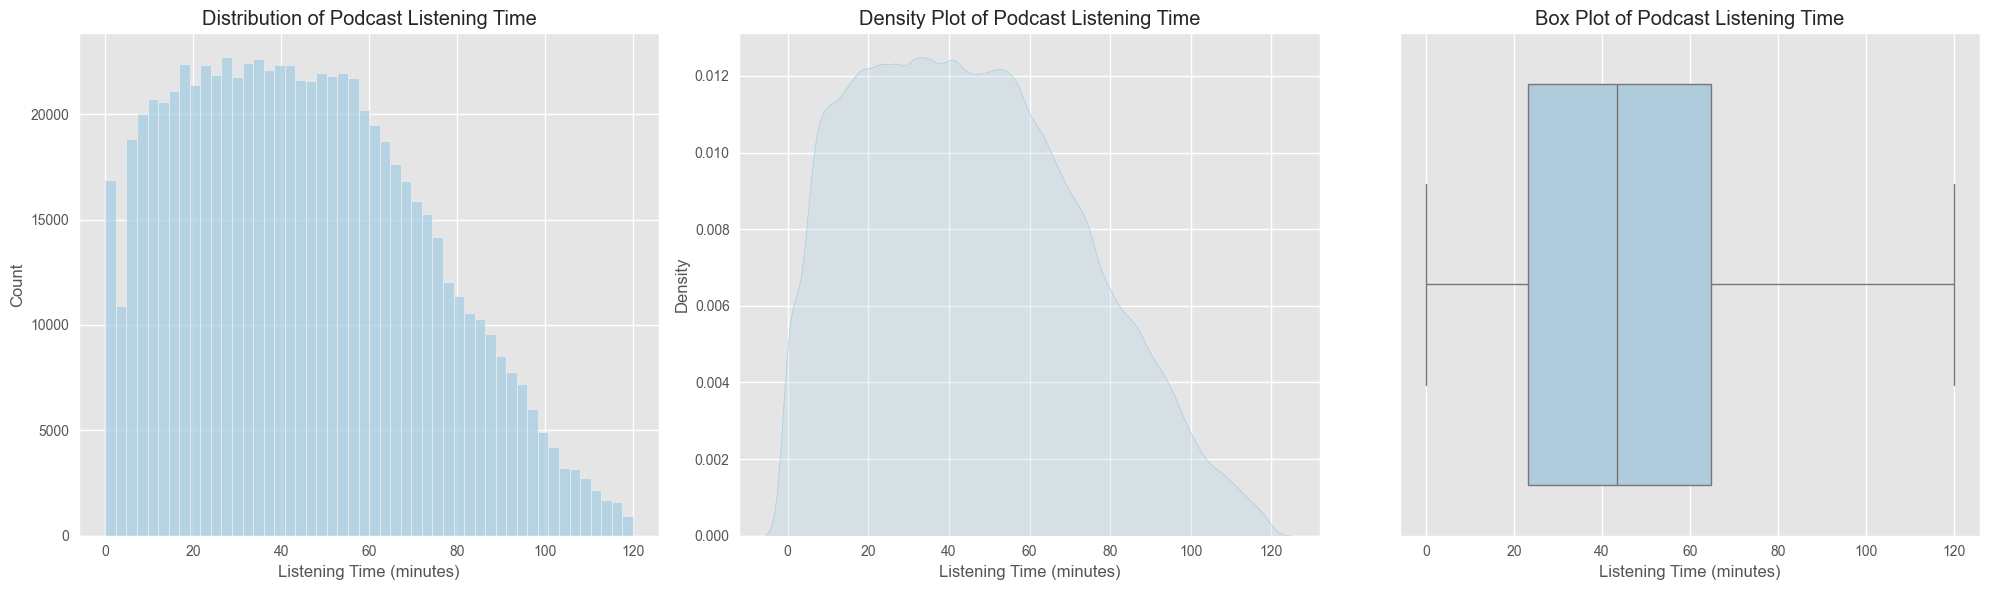


Target variable statistics:


count    750000.000000
mean         45.437406
std          27.138306
min           0.000000
25%          23.178350
50%          43.379460
75%          64.811580
max         119.970000
Name: Listening_Time_minutes, dtype: float64

In [11]:
# Create a figure with 3 subplots in a row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Distribution plot
sns.histplot(data=train, x='Listening_Time_minutes', bins=50, ax=ax1)
ax1.set_title('Distribution of Podcast Listening Time')
ax1.set_xlabel('Listening Time (minutes)')
ax1.set_ylabel('Count')

# Density plot
sns.kdeplot(train['Listening_Time_minutes'], fill=True, ax=ax2)
ax2.set_title('Density Plot of Podcast Listening Time')
ax2.set_xlabel('Listening Time (minutes)')
ax2.set_ylabel('Density')

# Box plot
sns.boxplot(x='Listening_Time_minutes', data=train, ax=ax3)
ax3.set_title('Box Plot of Podcast Listening Time')
ax3.set_xlabel('Listening Time (minutes)')

plt.tight_layout()
plt.show()


# Basic statistics of the target variable
print("\nTarget variable statistics:")
train['Listening_Time_minutes'].describe()

# Insights from the Listening Time density plot:
- 1. The distribution is right-skewed (positively skewed), with a longer tail extending towards higher listening times
- 2. The peak density occurs around 40-45 minutes, suggesting this is the most common listening duration
- 3. There is a gradual decline in density after the peak, indicating fewer instances of longer listening times
- 4. Very few listeners continue beyond 100 minutes
- 5. There appears to be a small secondary peak around 20-25 minutes, possibly indicating a common shorter listening duration
- 6. The distribution starts at 0 minutes but has very low density there, showing that most users listen for at least some time

## Implications:
- Content creators should aim for 40-45 minute episodes as this appears to be the optimal length
- There may be an opportunity for shorter format content around 20-25 minutes
- Episodes longer than 100 minutes may see significant drop-off in listener engagement
- Very short episodes (<5 minutes) are unlikely to retain listeners
- The right skew suggests some listeners are willing to engage with longer content, but they are in the minority

# For numerical features

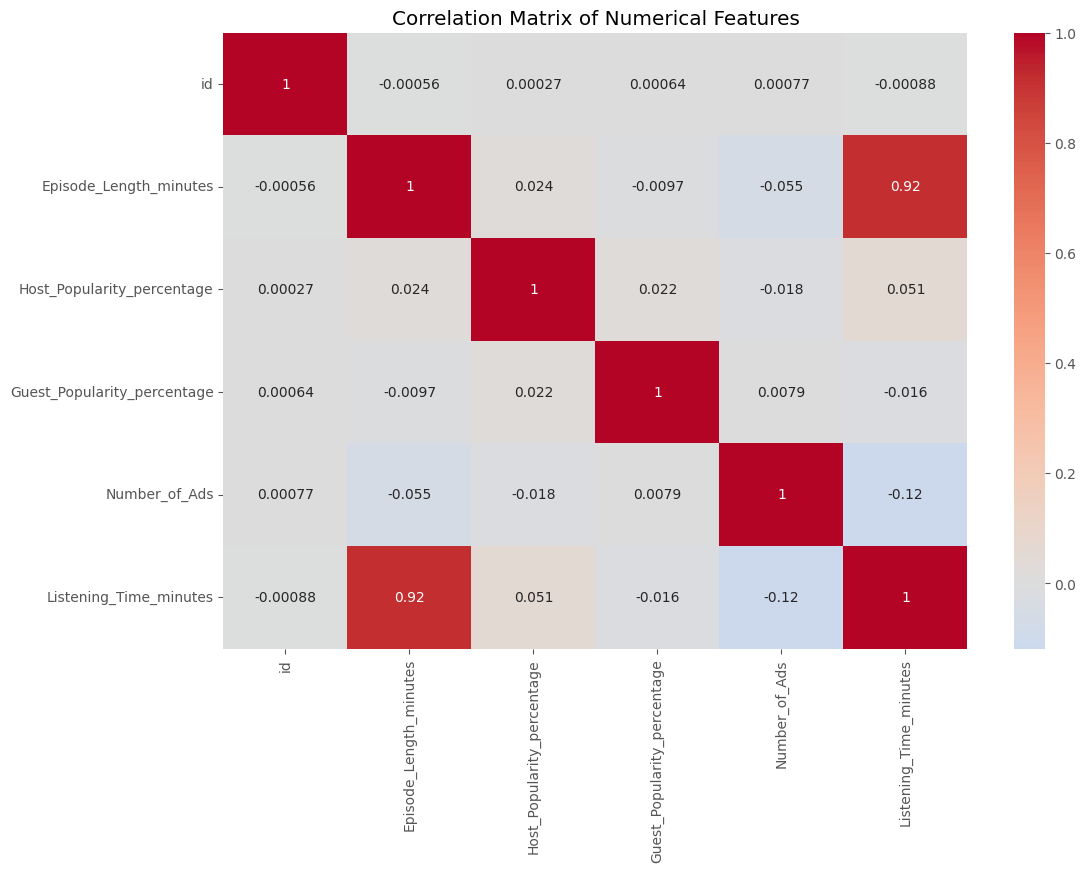

In [13]:
# Correlation analysis
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = train[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Key observations:
- 1. Episode length has a moderate positive correlation (0.92) with listening time
- 2. Number of ads shows very weak negative correlation (-0.12) with listening time
- 3. Host and guest popularity percentages have minimal correlation with listening time
- 4. Most features show weak correlations with each other (correlation < 0.1)
- 5. The correlation matrix suggests that the features are largely independent

## Implications:
- Longer episodes tend to have longer listening times, suggesting listeners are willing to commit more time to longer content
- The weak negative correlation with ads indicates that more ads slightly decrease listening time, but the effect is minimal
- Host and guest popularity surprisingly don't drive listening time significantly, suggesting content quality may matter more
- The independence between features means each variable likely contributes unique information for predicting listening time
- Feature selection may not need to consider multicollinearity issues since features aren't strongly correlated

# For categorical features:

C:\Users\ricar\AppData\Local\Temp\ipykernel_12164\2456331521.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  anova_results = pd.concat([anova_results, pd.DataFrame({


ANOVA Results for Categorical Variables vs. Listening Time
----------------------------------------------------------------------
             Feature  F-statistic        p-value Significant
5  Episode_Sentiment   586.007119  5.000200e-255        True
4   Publication_Time   151.767360   2.479230e-98        True
2              Genre    45.482308   1.467947e-82        True
1      Episode_Title    44.384362   0.000000e+00        True
0       Podcast_Name    42.095208   0.000000e+00        True
3    Publication_Day    40.510059   1.270200e-49        True


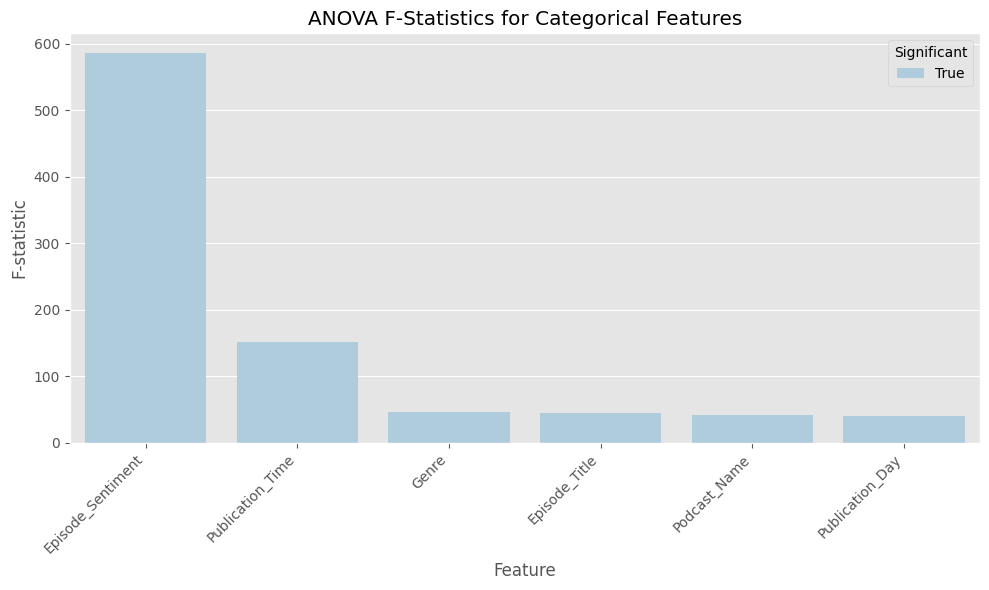

In [7]:
# Identify categorical columns
categorical_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

# Create a dataframe to store ANOVA results
anova_results = pd.DataFrame(columns=['Feature', 'F-statistic', 'p-value', 'Significant'])

# Loop through each categorical feature and perform ANOVA
for col in categorical_cols:
    # Create groups based on categories
    groups = []
    categories = train[col].unique()
    
    for category in categories:
        # Get listening times for this category
        group = train[train[col] == category]['Listening_Time_minutes'].dropna().values
        groups.append(group)
    
    # Perform one-way ANOVA
    f_stat, p_value = stats.f_oneway(*groups)
    
    # Add results to dataframe
    anova_results = pd.concat([anova_results, pd.DataFrame({
        'Feature': [col],
        'F-statistic': [f_stat],
        'p-value': [p_value],
        'Significant': [p_value < 0.05]
    })], ignore_index=True)

# Sort by F-statistic to see which categories have strongest effect
anova_results = anova_results.sort_values('F-statistic', ascending=False)

# Display results
print("ANOVA Results for Categorical Variables vs. Listening Time")
print("-" * 70)
print(anova_results)

# Visualize significant features
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='F-statistic', hue='Significant', data=anova_results)
plt.xticks(rotation=45, ha='right')
plt.title('ANOVA F-Statistics for Categorical Features')
plt.tight_layout()
plt.show()

## Insights
 - All categorical variables significantly influence listening time, but **Episode_Sentiment** and **Publication_Time** are particularly powerful predictors that should be prioritized in your modeling approach.

# Visualize density distributions

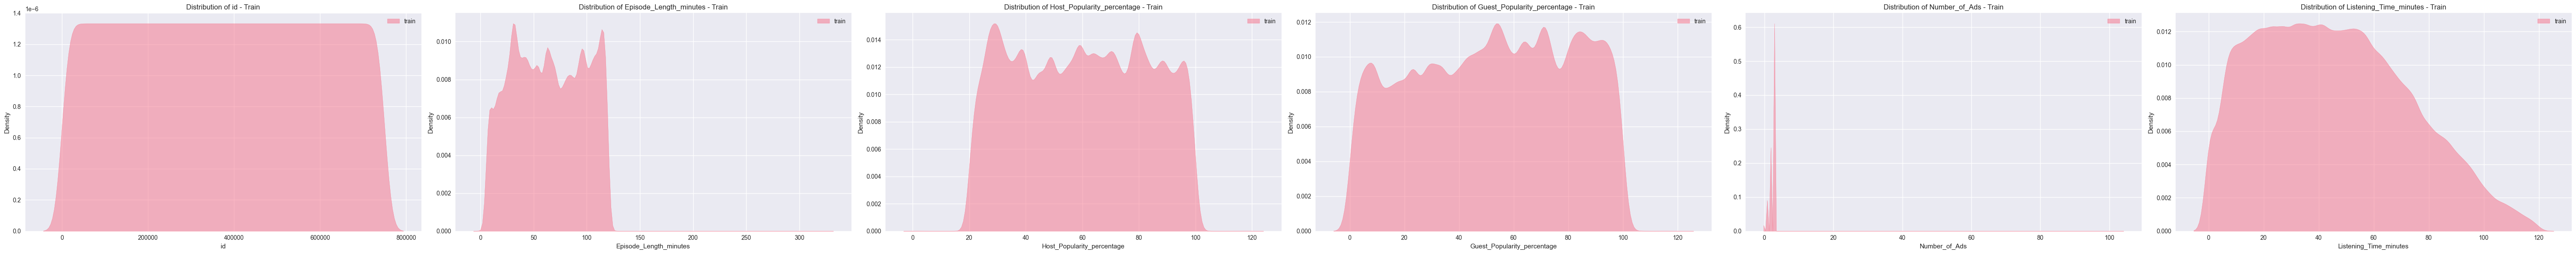

In [38]:
# Identify numerical columns
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns

# Create a single figure with subplots in one row
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(10*len(numerical_cols), 6))

# Compare distributions of features between train and test
for i, col in enumerate(numerical_cols):
    sns.kdeplot(data=train[col], ax=axes[i], alpha=0.5, label='train', fill=True)
    axes[i].set_title(f'Distribution of {col} - Train')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Analyze insights from the density plots

## Listening Time Distribution
- Right-skewed distribution with most listeners spending 20-60 minutes
- Long tail extending to 120 minutes  
- Peak around 40-45 minutes suggesting typical episode length preference

## Episode Length Distribution
- Similar right-skewed pattern as listening time
- Most episodes are 30-90 minutes long
- Some outlier episodes extending to over 300 minutes

## Host Popularity Distribution
- Roughly normal distribution centered around 60%
- Most hosts have popularity between 40-80%
- Small number of highly popular hosts >90%

## Guest Popularity Distribution
- Bimodal distribution with peaks around 30% and 75%
- More variable than host popularity
- Notable gap in mid-range popularity (45-60%)

## Number of Ads Distribution
- Highly right-skewed
- Most episodes have 0-3 ads
- Few outliers with very high ad counts

## Implications for Predicting Listening Time
- The similar shapes of listening time and episode length distributions suggest a strong correlation - episode length will likely be a key predictor
- The normal distribution of host popularity indicates it could provide stable predictive signal
- Guest popularity's bimodal distribution suggests we may need to bin this feature or use non-linear modeling approaches
- The highly skewed ad distribution may require transformation or binning to be useful for prediction
- Consider handling outliers in episode length and number of ads to improve model stability

# Visualize Categorical frequency

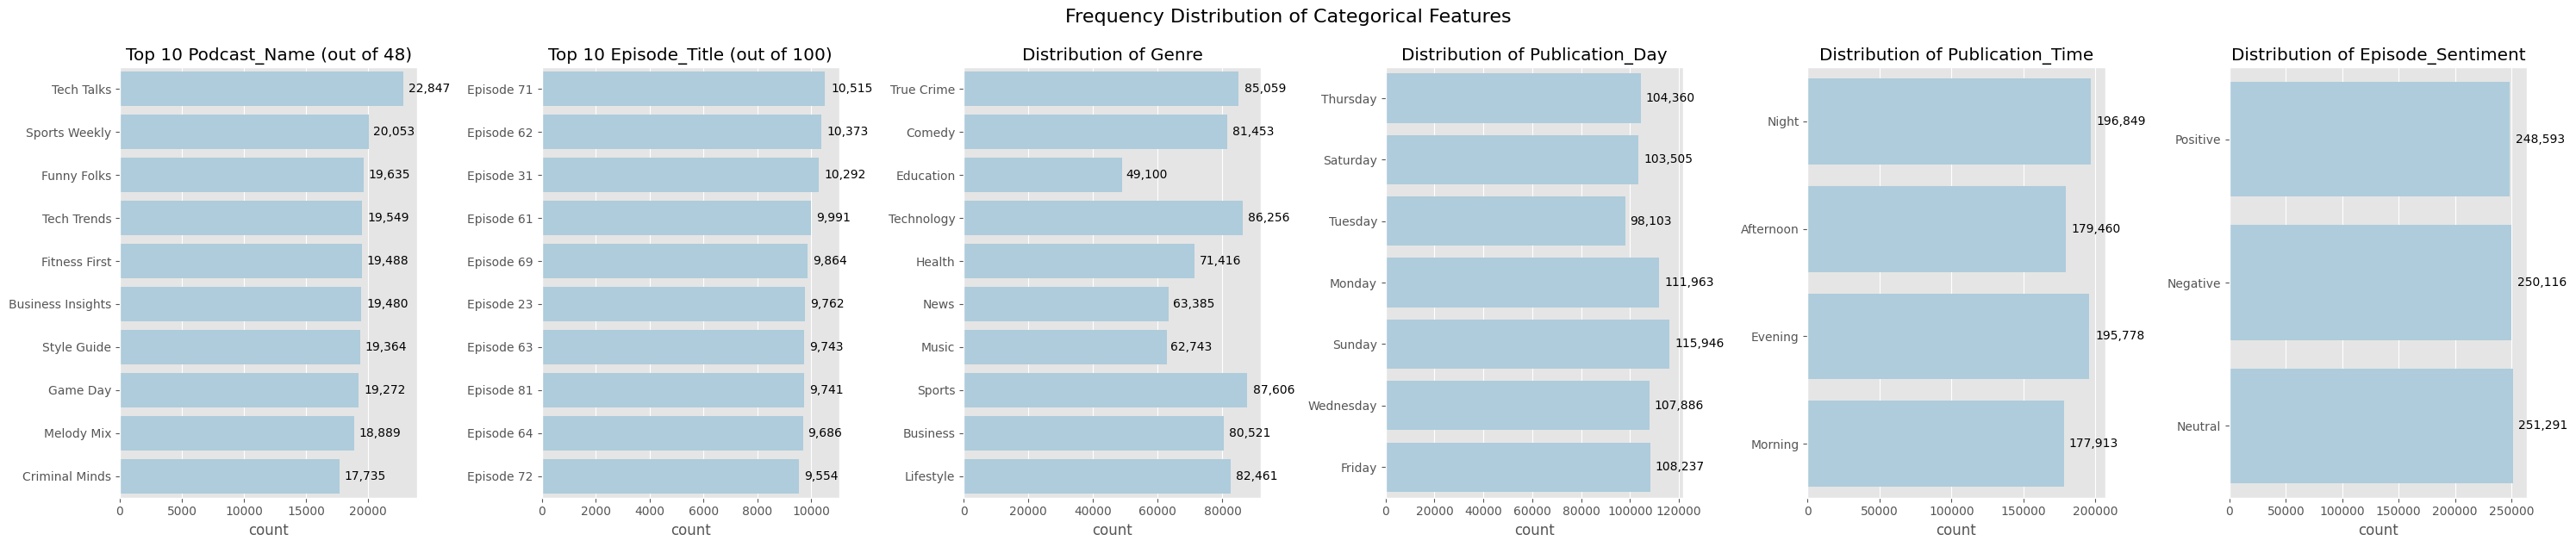

In [10]:
# Identify categorical columns
categorical_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

# Set figure size - adjust based on number of columns
fig_width = 5 * len(categorical_cols)
fig, axes = plt.subplots(1, len(categorical_cols), figsize=(fig_width, 6))

# Loop through each categorical column and create a plot
for i, col in enumerate(categorical_cols):
    # Count plot for each categorical feature
    unique_vals = train[col].nunique()
    
    # For columns with many unique values, just show top 10
    if unique_vals > 10:
        # Get top 10 values by frequency
        top_values = train[col].value_counts().nlargest(10).index
        # Filter dataframe to only include top values
        plot_data = train[train[col].isin(top_values)]
        sns.countplot(y=col, data=plot_data, ax=axes[i], order=top_values)
        axes[i].set_title(f'Top 10 {col} (out of {unique_vals})')
    else:
        # For columns with few values, plot all
        sns.countplot(y=col, data=train, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
    
    # Improve readability
    axes[i].tick_params(axis='y', labelsize=10)
    axes[i].set_ylabel('')
    
    # Add count labels
    for p in axes[i].patches:
        width = p.get_width()
        axes[i].text(width + width*0.02, 
                    p.get_y() + p.get_height()/2,
                    f'{int(width):,}', 
                    ha='left', va='center')

plt.tight_layout()
plt.suptitle('Frequency Distribution of Categorical Features', fontsize=16, y=1.05)
plt.show()

# Categorical Feature Distribution Insights:

## 1. Genre Distribution:
- Most common genre: Sports (87,606 episodes)
- Least common genre: Education (49,100 episodes)

## 2. Publication Day Distribution:
- Most common day: Sunday (115,946 episodes)
- Least common day: Tuesday (98,103 episodes)

## 3. Publication Time Distribution:
- Most common time: Night (196,849 episodes)
- Least common time: Morning (177,913 episodes)

## 4. Episode Sentiment Distribution:
- Most common sentiment: Neutral (251,291 episodes)
- Least common sentiment: Positive (248,593 episodes)

## 5. Podcast Distribution:
- Number of unique podcasts: 48
- Most frequent podcast: Tech Talks (22,847 episodes)
- Least frequent podcast: News Roundup (9,169 episodes)

## 6. Implications:
- The categorical distributions show varying levels of content availability across different features
- The relatively balanced distribution across genres (49k-87k episodes) suggests listeners have good variety
- Publication timing is also fairly balanced, with no extreme skews in days or times
- The even split between sentiment categories (~250k each) indicates balanced emotional content
- The podcast distribution shows some concentration (22k vs 9k episodes), which may affect listening patterns
- These distributions help understand what content types are available to drive listening time

# Analysis of Text Base features

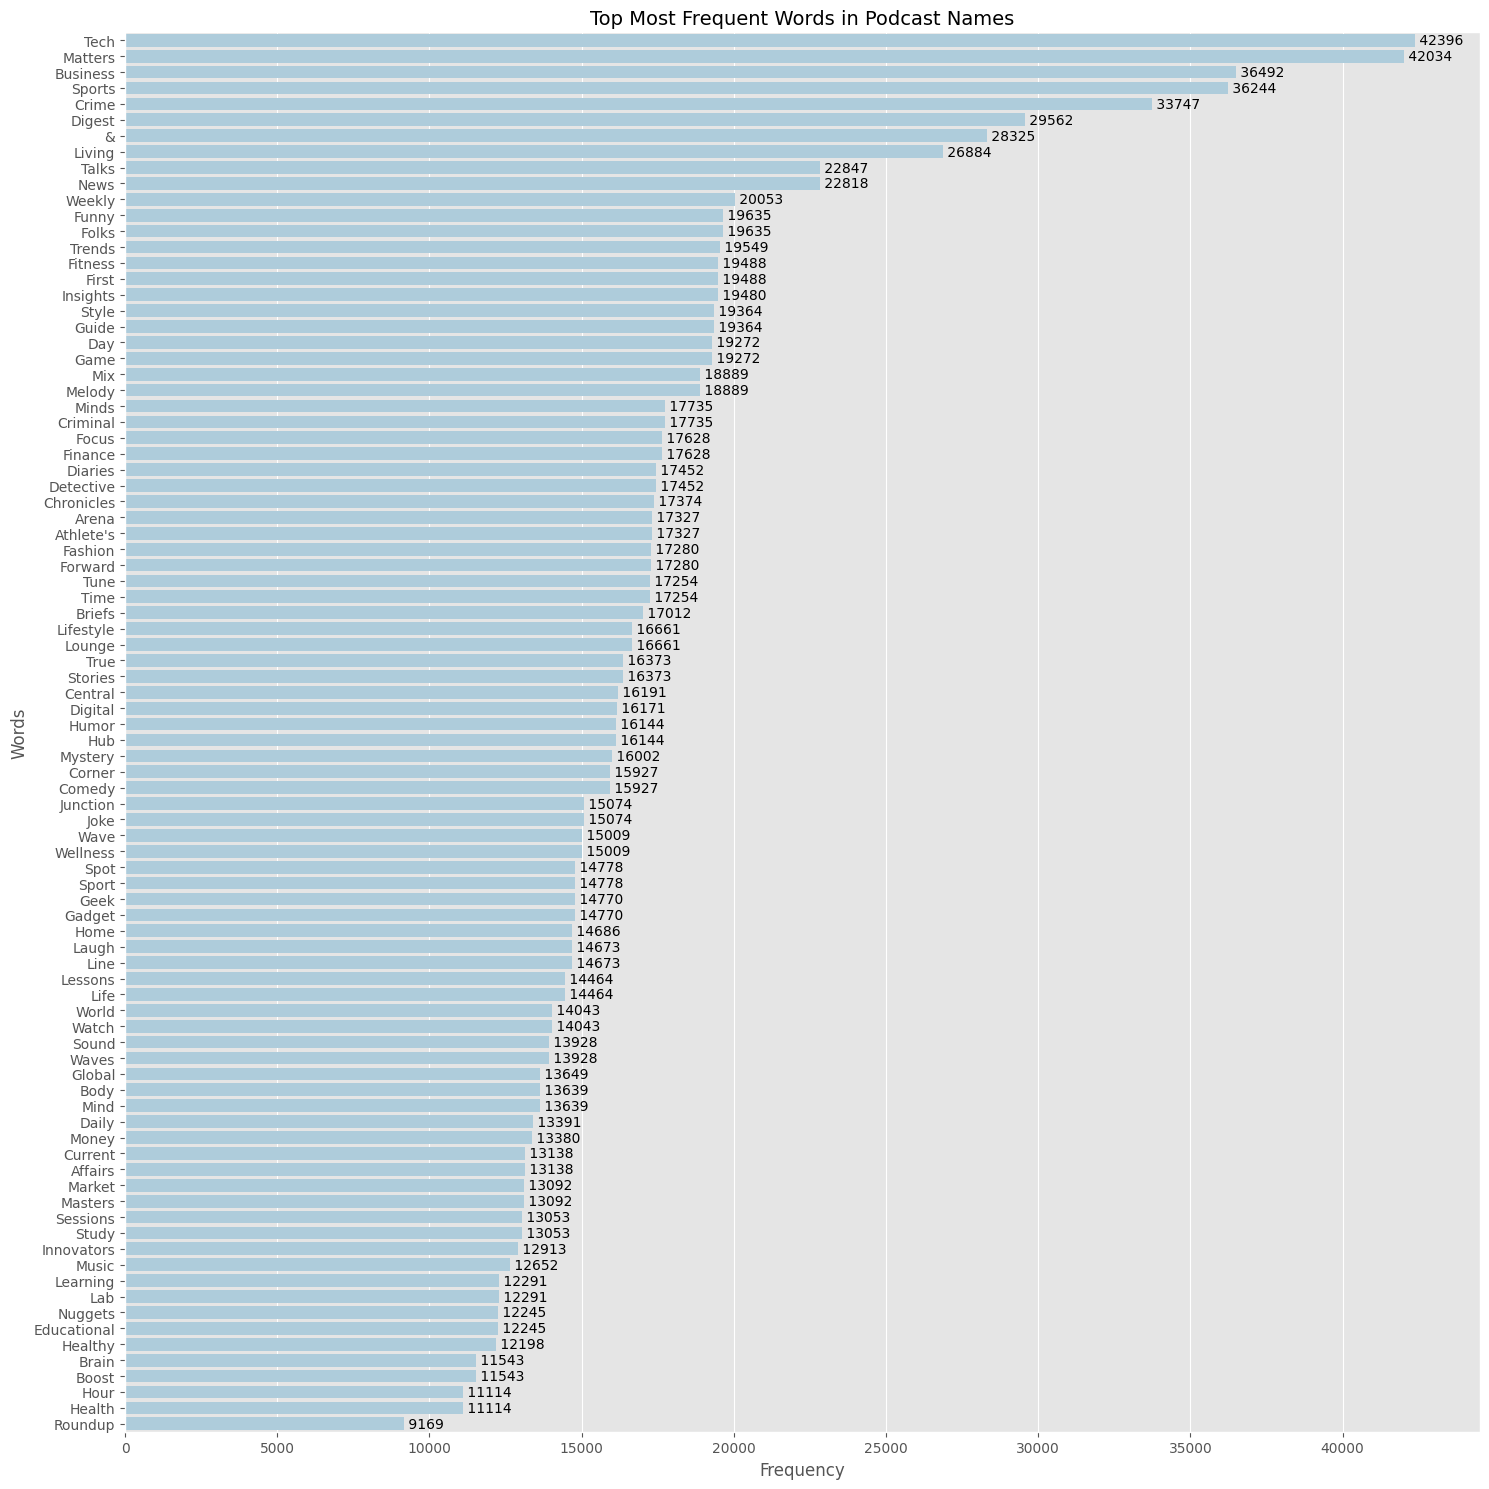

In [26]:
# Podcast Name Analysis

# Split podcast names into words and analyze frequency
podcast_words = train['Podcast_Name'].str.split().explode()
word_counts = podcast_words.value_counts().sort_values(ascending=False)#.head(50)

plt.figure(figsize=(15,15))
sns.barplot(x=word_counts.values, y=word_counts.index)
plt.title('Top Most Frequent Words in Podcast Names', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)

# Add value labels on bars
for i, v in enumerate(word_counts.values):
    plt.text(v, i, f' {v}', va='center')

plt.tight_layout()
plt.show()

# Improvements 
- Grouping Title Words for Feature Engineering